# gridfinder
Run through the full gridfinder model from data input to final guess for Burundi.
Note that the 'truth' data used for the grid here is very bad, so the accuracy results don't mean much.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import display, Markdown

import numpy as np
import rasterio
import geopandas as gpd
import folium

import gridfinder as gf
from gridfinder import save_raster

## Set folders and parameters

In [2]:
folder_inputs = Path('test_data')
folder_ntl_in = folder_inputs / 'ntl'
aoi_in = folder_inputs / 'adm0.gpkg'
roads_in = folder_inputs / 'roads.gpkg'
pop_in = folder_inputs / 'pop.tif'
grid_truth = folder_inputs / 'grid.gpkg'

folder_out = Path('test_output')
folder_ntl_out = folder_out / 'ntl_clipped'
raster_merged_out = folder_out / 'ntl_merged.tif'
targets_out = folder_out / 'targets.tif'
targets_clean_out = folder_out / 'targets_clean.tif'
roads_out = folder_out / 'roads.tif'

dist_out = folder_out / 'dist.tif'
guess_out = folder_out / 'guess.tif'
guess_skeletonized_out = folder_out / 'guess_skel.tif'
guess_nulled = folder_out / 'guess_nulled.tif'
guess_vec_out = folder_out / 'guess.gpkg'
animate_out = folder_out / 'animated'

In [3]:
percentile = 70      # percentile value to use when merging monthly NTL rasters
ntl_threshold = 0.1  # threshold when converting filtered NTL to binary (probably shouldn't change)
upsample_by = 2      # factor by which to upsample before processing roads (both dimensions are scaled by this)
cutoff = 0.5         # cutoff to apply to output dist raster, values below this are considered grid

## Clip  and merge monthly rasters

In [4]:
gf.clip_rasters(folder_ntl_in, folder_ntl_out, aoi_in)

Merged


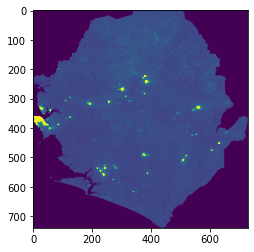

In [5]:
raster_merged, affine = gf.merge_rasters(folder_ntl_out, percentile=percentile)
save_raster(raster_merged_out, raster_merged, affine)
print('Merged')
plt.imshow(raster_merged, vmin=0, vmax=1)

## Create filter

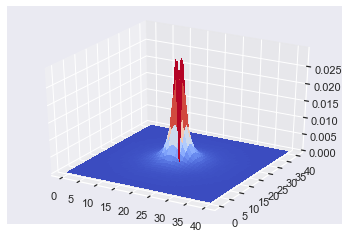

In [6]:
ntl_filter = gf.create_filter()

X = np.fromfunction(lambda i, j: i, ntl_filter.shape)
Y = np.fromfunction(lambda i, j: j, ntl_filter.shape)

fig = plt.figure()
sns.set()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, ntl_filter, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Clip, filter and resample NTL

Targets prepared


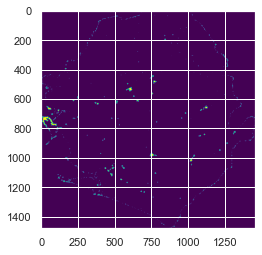

In [7]:
ntl_thresh, affine = gf.prepare_ntl(raster_merged_out,
                                    aoi_in,
                                    ntl_filter=ntl_filter,
                                    threshold=ntl_threshold,
                                    upsample_by=upsample_by)
save_raster(targets_out, ntl_thresh, affine)
print('Targets prepared')
plt.imshow(ntl_thresh, cmap='viridis')

## Remove target areas with no underlying population

Removed zero pop


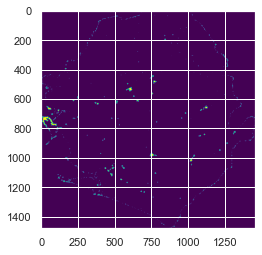

In [8]:
targets_clean = gf.drop_zero_pop(targets_out, pop_in, aoi_in)
save_raster(targets_clean_out, targets_clean, affine)
print('Removed zero pop')
plt.imshow(ntl_thresh, cmap='viridis')

## Roads: assign values, clip and rasterize

Costs prepared


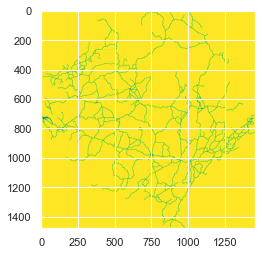

In [9]:
roads_raster, affine = gf.prepare_roads(roads_in,
                                        aoi_in,
                                        targets_out)
save_raster(roads_out, roads_raster, affine, nodata=-1)
print('Costs prepared')
plt.imshow(roads_raster, cmap='viridis', vmin=0, vmax=1)

In [10]:
settlements_in = folder_inputs / 'grid_clusters.gpkg'
settlements_out = folder_out / 'grid_clusters.tif'

Costs prepared


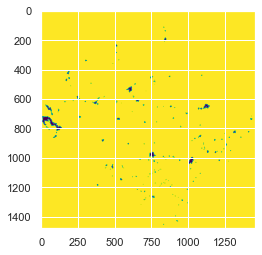

In [12]:
settlements_raster, affine = gf.prepare_settlements(settlements_in,
                                        aoi_in,
                                        targets_out)

save_raster(settlements_out, settlements_raster, affine, nodata=1)
print('Costs prepared')
plt.imshow(settlements_raster, cmap='viridis', vmin=0, vmax=1)

In [13]:
settlements_out = folder_out / 'grid_clusters_updated.tif'

In [14]:
targets, costs, start, affine = gf.get_targets_costs(settlements_out, roads_out)
est_mem = gf.estimate_mem_use(targets, costs)
print(f'Estimated memory usage: {est_mem:.2f} GB')

Estimated memory usage: 0.04 GB


'99.00 %'

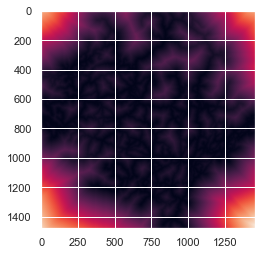

In [15]:
dist = gf.optimise(targets, costs, start,
                   jupyter=True,
                   animate=True,
                   affine=affine,
                   animate_path=animate_out)
save_raster(dist_out, dist, affine)
plt.imshow(dist)

Got guess


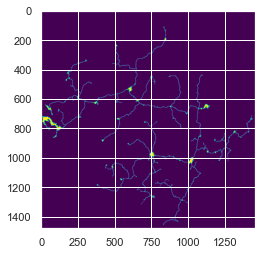

In [16]:
guess, affine = gf.threshold(dist_out, cutoff=cutoff)
save_raster(guess_out, guess, affine)
print('Got guess')
plt.imshow(guess, cmap='viridis')

In [17]:
true_pos, false_neg = gf.accuracy(grid_truth, guess_out, aoi_in)
print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

C:\Users\alexl\Dropbox\GitHub\gridfinder\gridfinder\post.py:200: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_buff = grid.buffer(buffer_amount)


Points identified as grid that are grid: 74%
Actual grid that was missed: 50%


Skeletonized


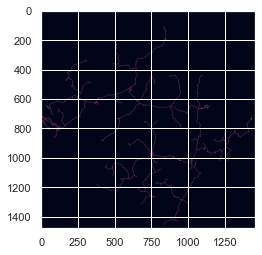

In [18]:
guess_skel, affine = gf.thin(guess_out)
save_raster(guess_skeletonized_out, guess_skel, affine)
print('Skeletonized')
plt.imshow(guess_skel)

In [19]:
guess_gdf = gf.raster_to_lines(guess_skeletonized_out)
guess_gdf.to_file(guess_vec_out, driver='GPKG')
print('Converted to geom')

Converted to geom


In [28]:
path = r"C:\Users\alexl\Dropbox\GitHub\gridfinder\test_data"
name = 'grid_clusters.gpkg'

In [29]:
gep_grid_clusters_gdf = gpd.read_file(path + '\\' + name)

In [1]:
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

m = folium.Map(control_scale=True)
m.fit_bounds(bounds)

clusters = folium.FeatureGroup(name="GEP grid clusters")
clusters.add_child(folium.GeoJson(gep_grid_clusters_gdf))
m.add_child(clusters)
                   
grid = folium.FeatureGroup(name="Grid Networks")
grid.add_child(folium.GeoJson(guess_gdf))
m.add_child(grid)                   
                   
folium.GeoJson(guess_gdf).add_to(m)
folium.LayerControl().add_to(m)
#m

NameError: name 'guess_gdf' is not defined

## Get targets and costs and run algorithm

In [18]:
targets, costs, start, affine = gf.get_targets_costs(targets_clean_out, roads_out)
est_mem = gf.estimate_mem_use(targets, costs)
print(f'Estimated memory usage: {est_mem:.2f} GB')

Estimated memory usage: 0.04 GB


'99.00 %'

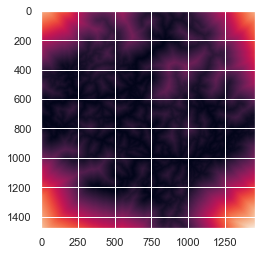

In [19]:
dist = gf.optimise(targets, costs, start,
                   jupyter=True,
                   animate=True,
                   affine=affine,
                   animate_path=animate_out)
save_raster(dist_out, dist, affine)
plt.imshow(dist)

## Filter dist results to grid guess

Got guess


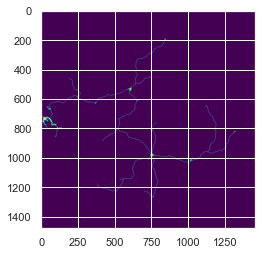

In [12]:
guess, affine = gf.threshold(dist_out, cutoff=cutoff)
save_raster(guess_out, guess, affine)
print('Got guess')
plt.imshow(guess, cmap='viridis')

## Check results

In [13]:
true_pos, false_neg = gf.accuracy(grid_truth, guess_out, aoi_in)
print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

C:\Users\alexl\Dropbox\GitHub\gridfinder\gridfinder\post.py:200: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_buff = grid.buffer(buffer_amount)


Points identified as grid that are grid: 82%
Actual grid that was missed: 76%


## Skeletonize

Skeletonized


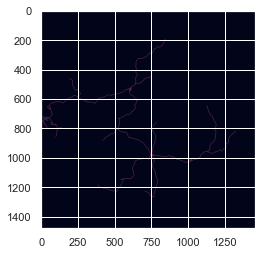

In [14]:
guess_skel, affine = gf.thin(guess_out)
save_raster(guess_skeletonized_out, guess_skel, affine)
print('Skeletonized')
plt.imshow(guess_skel)

## Convert to geometry

In [15]:
guess_gdf = gf.raster_to_lines(guess_skeletonized_out)
guess_gdf.to_file(guess_vec_out, driver='GPKG')
print('Converted to geom')

Converted to geom


In [2]:
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

m = folium.Map(control_scale=True)
m.fit_bounds(bounds)
folium.GeoJson(guess_gdf).add_to(m)
#m

NameError: name 'guess_gdf' is not defined